In [1]:
from ekonlpy.sentiment import MPCK
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

## 금융통화위원회 의사록 어조 분석
- 의사록 어조 측정
1. 문장 : 금리 사전을 기반으로 긍/부정 카운트 후, 문장의 어조 계산 (문장 tone = (Pos - Neg) / (Pos + Neg))
2. 문서 : 문장의 어조를 계산한 값으로 0보다 크면 "Hawkish", 작으면 "Dovish"로 나누어 다시 문서 전체의 어조 계산 (문서 tone = (Pos - Neg) / (Pos + Neg))

In [2]:
# 금리 상승/하락 사전
pos_dict = pd.read_csv("../data/pos_dict.csv")
neg_dict = pd.read_csv("../data/neg_dict.csv")
# 금융통화위원회 의사록
min_df = pd.read_csv("../data/minutes_contents.csv")
# 기준 금리
base_df = pd.read_csv("../data/baserate.csv")

mpck = MPCK()

# 각 사전의 단어들을 리스트로 분류
pos_list = pos_dict["word"].to_list()
neg_list = neg_dict["word"].to_list()
min_df

,date,title,contents
0,2005-06-09,금융통화위원회 의사록(2005년도 제12차)(2005.6.9).txt,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...
1,2005-07-07,금융통화위원회 의사록(2005년도 제14차)(2005.7.7).txt,일부 위원은 6월 들어 국제유가가 크게 오르고 원화와 엔화간 동조화 현상이 뚜렷...
2,2005-08-11,금융통화위원회 의사록(2005년도 제17차)(2005.8.11).txt,일부 위원은 위안화 절상 이후 아시아 통화중 우리나라 원화의 절상폭이 가장 컸다...
3,2005-09-08,금융통화위원회 의사록(2005년도 제19차)(2005.9.8).txt,일부 위원은 최근 인도네시아 금융불안 사태가 발생한 가운데 국제 환투기세력이 인...
4,2005-10-11,금융통화위원회 의사록(2005년도 제21차)(2005.10.11).txt,일부 위원은 미국과 우리나라의 정책금 리 격차가 확대되고 있는 가운데 금년 두 차...
...,...,...,...
121,2016-02-16,금융통화위원회 의사록(2016년도 제3차)(2016.2.16).txt,일부 위원은 도이치은행의 최근 상황과 이 에 따른 시장의 영향에 대한 관련부서의 ...
122,2016-03-10,금융통화위원회 의사록(2016년도 제5차)(2016.3.10.).txt,일부 위원은 지난 5년간 미 달러화대비 주 요국 통화의 흐름을 살펴보면 원화가치의...
123,2016-04-19,금융통화위원회 의사록(2016년도 제7차)(2016.4.19.).txt,일부 위원은 최근 원화가치의 절상폭이 확 대되고 있는 가운데 미국 BHC(Benn...
124,2016-05-13,금융통화위원회 의사록(2016년도 제9차)(2016.5.13.).txt,일부 위원은 국내 통화정책 운영의 가장 중 - 7 - 요한 대외 리스크로 주...


#### 데이터 전처리 함수

In [3]:
# 토큰화 + n-gram화
def stc_ngram(sentence):
    tokens = mpck.tokenize(sentence)
    ngrams = mpck.ngramize(tokens)
    result = tokens + ngrams
    return result

# 문장 어조 계산 후 라벨링
def get_label(df) :
    if df["tone_doc"] > 0 :
        return "Hawkish"
    elif df["tone_doc"] < 0 :
        return "Dovish"

## 금리 사전을 기반으로 긍/부정 카운트 후, 문장의 어조 계산

In [4]:
# 문장 tone 카운트 컬럼 생성
min_df["pos_cnt"] = np.nan
min_df["neg_cnt"] = np.nan

for i in tqdm(range(len(min_df))) :
    # 문장 tone의 최종 카운트가 될 변수
    pos_count = 0
    neg_count = 0
    sentences = min_df["contents"][i].split("@@@")
    for sentence in sentences :
        # 문서 별 문장 tone 카운트 변수
        up_count = 0
        down_count = 0
        # tokenize + ngramize
        ngram_list = stc_ngram(sentence)
        for ngram in ngram_list :
            if ngram in pos_list : # 금리 상승 사전
                up_count += 1
            elif ngram in neg_list : # 금리 하락 사전
                down_count += 1
        try: # sentence_tone 어조 계산
            sentence_tone = (up_count - down_count) / (up_count + down_count)
        except ZeroDivisionError : # 연산 결과가 0
            sentence_tone = 0
        if sentence_tone > 0 :
            pos_count += 1 # 최종 pos 카운트
        elif sentence_tone < 0 :
            neg_count += 1 # 최종 neg 카운트
    # 최종 카운트를 DataFrame에 업데이트
    min_df.at[i, "pos_cnt"] = pos_count
    min_df.at[i, "neg_cnt"] = neg_count
min_df.head(5)

100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:59<00:00,  1.05it/s]


,date,title,contents,pos_cnt,neg_cnt
0,2005-06-09,금융통화위원회 의사록(2005년도 제12차)(2005.6.9).txt,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,34.0,79.0
1,2005-07-07,금융통화위원회 의사록(2005년도 제14차)(2005.7.7).txt,일부 위원은 6월 들어 국제유가가 크게 오르고 원화와 엔화간 동조화 현상이 뚜렷...,37.0,80.0
2,2005-08-11,금융통화위원회 의사록(2005년도 제17차)(2005.8.11).txt,일부 위원은 위안화 절상 이후 아시아 통화중 우리나라 원화의 절상폭이 가장 컸다...,39.0,90.0
3,2005-09-08,금융통화위원회 의사록(2005년도 제19차)(2005.9.8).txt,일부 위원은 최근 인도네시아 금융불안 사태가 발생한 가운데 국제 환투기세력이 인...,38.0,85.0
4,2005-10-11,금융통화위원회 의사록(2005년도 제21차)(2005.10.11).txt,일부 위원은 미국과 우리나라의 정책금 리 격차가 확대되고 있는 가운데 금년 두 차...,33.0,80.0


In [5]:
# 문장의 어조를 계산하여 문서의 어조 라벨링 컬럼 생성
min_df["tone_doc"] = (min_df["pos_cnt"] - min_df["neg_cnt"]) / (min_df["pos_cnt"] + min_df["neg_cnt"])
min_df["tone_doc_label"] = min_df.apply(get_label, axis = 1) # get_label() 함수 호출하여 tone_doc_label 컬럼 생성
print(len(min_df))
min_df.head(5)

126


,date,title,contents,pos_cnt,neg_cnt,tone_doc,tone_doc_label
0,2005-06-09,금융통화위원회 의사록(2005년도 제12차)(2005.6.9).txt,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,34.0,79.0,-0.398230,Dovish
1,2005-07-07,금융통화위원회 의사록(2005년도 제14차)(2005.7.7).txt,일부 위원은 6월 들어 국제유가가 크게 오르고 원화와 엔화간 동조화 현상이 뚜렷...,37.0,80.0,-0.367521,Dovish
2,2005-08-11,금융통화위원회 의사록(2005년도 제17차)(2005.8.11).txt,일부 위원은 위안화 절상 이후 아시아 통화중 우리나라 원화의 절상폭이 가장 컸다...,39.0,90.0,-0.395349,Dovish
3,2005-09-08,금융통화위원회 의사록(2005년도 제19차)(2005.9.8).txt,일부 위원은 최근 인도네시아 금융불안 사태가 발생한 가운데 국제 환투기세력이 인...,38.0,85.0,-0.382114,Dovish
4,2005-10-11,금융통화위원회 의사록(2005년도 제21차)(2005.10.11).txt,일부 위원은 미국과 우리나라의 정책금 리 격차가 확대되고 있는 가운데 금년 두 차...,33.0,80.0,-0.415929,Dovish


In [6]:
# 문장, 문서의 어조 계산 결과 저장
min_df.to_csv("../data/minutes_tone_result.csv", encoding = "utf-8")

In [7]:
# 기준 금리 데이터 확인
print(len(base_df))
base_df.head(5)

4715


,date,rate
0,2005-01-03,3.25
1,2005-01-04,3.25
2,2005-01-05,3.25
3,2005-01-06,3.25
4,2005-01-07,3.25


In [8]:
# 의사록, 기준 금리 DataFrame 병합
b_m_df = pd.merge(min_df, base_df, on = "date", how = "inner")
b_m_df = b_m_df.dropna()
b_m_df

,date,title,contents,pos_cnt,neg_cnt,tone_doc,tone_doc_label,rate
0,2005-06-09,금융통화위원회 의사록(2005년도 제12차)(2005.6.9).txt,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,34.0,79.0,-0.398230,Dovish,3.25
1,2005-07-07,금융통화위원회 의사록(2005년도 제14차)(2005.7.7).txt,일부 위원은 6월 들어 국제유가가 크게 오르고 원화와 엔화간 동조화 현상이 뚜렷...,37.0,80.0,-0.367521,Dovish,3.25
2,2005-08-11,금융통화위원회 의사록(2005년도 제17차)(2005.8.11).txt,일부 위원은 위안화 절상 이후 아시아 통화중 우리나라 원화의 절상폭이 가장 컸다...,39.0,90.0,-0.395349,Dovish,3.25
3,2005-09-08,금융통화위원회 의사록(2005년도 제19차)(2005.9.8).txt,일부 위원은 최근 인도네시아 금융불안 사태가 발생한 가운데 국제 환투기세력이 인...,38.0,85.0,-0.382114,Dovish,3.25
4,2005-10-11,금융통화위원회 의사록(2005년도 제21차)(2005.10.11).txt,일부 위원은 미국과 우리나라의 정책금 리 격차가 확대되고 있는 가운데 금년 두 차...,33.0,80.0,-0.415929,Dovish,3.50
...,...,...,...,...,...,...,...,...
121,2016-02-16,금융통화위원회 의사록(2016년도 제3차)(2016.2.16).txt,일부 위원은 도이치은행의 최근 상황과 이 에 따른 시장의 영향에 대한 관련부서의 ...,2.0,31.0,-0.878788,Dovish,1.50
122,2016-03-10,금융통화위원회 의사록(2016년도 제5차)(2016.3.10.).txt,일부 위원은 지난 5년간 미 달러화대비 주 요국 통화의 흐름을 살펴보면 원화가치의...,2.0,29.0,-0.870968,Dovish,1.50
123,2016-04-19,금융통화위원회 의사록(2016년도 제7차)(2016.4.19.).txt,일부 위원은 최근 원화가치의 절상폭이 확 대되고 있는 가운데 미국 BHC(Benn...,2.0,37.0,-0.897436,Dovish,1.50
124,2016-05-13,금융통화위원회 의사록(2016년도 제9차)(2016.5.13.).txt,일부 위원은 국내 통화정책 운영의 가장 중 - 7 - 요한 대외 리스크로 주...,5.0,27.0,-0.687500,Dovish,1.50


## 의사록 어조와 기준 금리의 상관계수 산출

In [9]:
corre = b_m_df[["rate", "tone_doc"]].corr()
corre

,rate,tone_doc
rate,1.000000,0.556999
tone_doc,0.556999,1.000000


## 상관관계 시각화 그래프

### 🌟일별 그래프

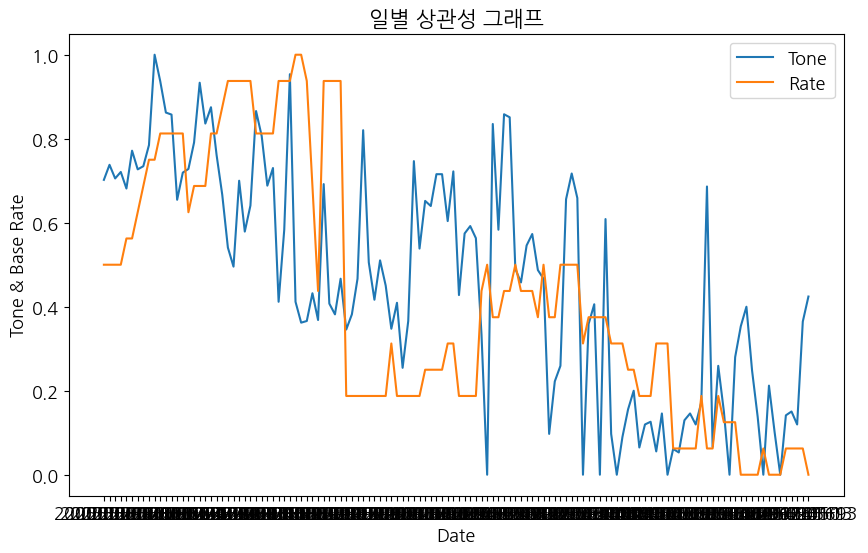

In [10]:
scaler = MinMaxScaler()

# x, y 넘파이 배열로 변환
x = np.array(b_m_df["date"])
y1 = np.array(b_m_df["tone_doc"]).reshape(-1, 1)
y2 = np.array(b_m_df["rate"]).reshape(-1, 1)

y1_scaled = scaler.fit_transform(y1)
y2_scaled = scaler.fit_transform(y2)

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize=(10, 6))

plt.plot(x, y1_scaled, label="Tone")
plt.plot(x, y2_scaled, label="Rate")

plt.xlabel("Date")
plt.ylabel("Tone & Base Rate")
plt.title("일별 상관성 그래프")
plt.legend()

plt.show()

### 🌟연도별 그래프

In [11]:
# 연도별 그래프를 출력하기 위해 기존 DataFrame을 reindex하여 새 DataFrame 생성
graph_df = b_m_df.reindex(columns = ["date", "tone_doc", "rate"])
print(len(graph_df))
graph_df.to_csv("../data/tone_rate.csv", encoding = "utf-8")
graph_df.head(5)

126


,date,tone_doc,rate
0,2005-06-09,-0.398230,3.25
1,2005-07-07,-0.367521,3.25
2,2005-08-11,-0.395349,3.25
3,2005-09-08,-0.382114,3.25
4,2005-10-11,-0.415929,3.50


In [12]:
# date 컬럼을 datetime 형식으로 변환
graph_df["date"] = pd.to_datetime(graph_df["date"])
# 연도 추출 컬럼 생성
graph_df["year"] = graph_df["date"].dt.year
graph_df.set_index("date", inplace=True)
# year로 groupby하여 tone_doc, rate의 평균 산출
grouped_df = graph_df.groupby("year").agg({
    "tone_doc": "mean",
    "rate": "mean"
}).reset_index()

print(len(grouped_df))
grouped_df

13


,year,tone_doc,rate
0,2005,-0.382095,3.392857
1,2006,-0.297256,4.229167
2,2007,-0.403619,4.729167
3,2008,-0.583076,4.791667
4,2009,-0.623226,2.041667
5,2010,-0.464891,2.166667
6,2011,-0.505575,2.958333
7,2012,-0.597765,3.062500
8,2013,-0.789902,2.666667
9,2014,-0.917947,2.300000


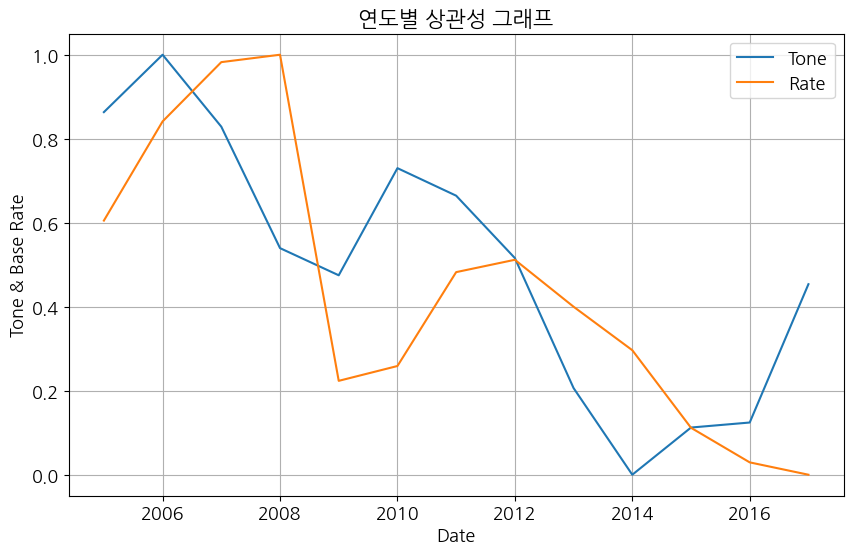

In [13]:
# x, y 넘파이 배열로 변환
x = np.array(grouped_df["year"])
y1 = np.array(grouped_df["tone_doc"]).reshape(-1, 1)
y2 = np.array(grouped_df["rate"]).reshape(-1, 1)

y1_scaled = scaler.fit_transform(y1)
y2_scaled = scaler.fit_transform(y2)

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (10, 6))

plt.plot(x, y1_scaled, label = "Tone")
plt.plot(x, y2_scaled, label = "Rate")

plt.xlabel("Date")
plt.ylabel("Tone & Base Rate")
plt.title("연도별 상관성 그래프")
plt.legend()
plt.grid(True)
plt.show()